In [1]:
!pip install opencv-python-headless


In [2]:
import cv2
print("OpenCV version:", cv2.__version__)


OpenCV version: 4.12.0


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

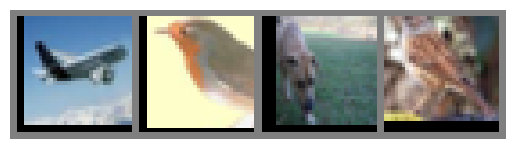

airplane bird dog bird


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to unnormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW to HWC
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))


In [9]:
import torch.nn as nn
import torch.nn.functional as F


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
# Create model instance and move to device
net = SimpleCNN()
net.to(device)

# Load trained model weights if you saved them (optional)
# net.load_state_dict(torch.load("model_v2.pth"))

# Set model to evaluation mode
net.eval()

print("Model architecture:")
print(net)

Model architecture:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
import torch
import torch.optim as optim

# Instantiate the model and move to device
net = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Training loop
for epoch in range(5):  # number of epochs
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f} | acc: {100 * correct / total:.2f}%")
            running_loss = 0.0

print('✅ Finished Training with Regularization')


[1, 100] loss: 2.284 | acc: 13.48%
[1, 200] loss: 2.184 | acc: 17.08%
[1, 300] loss: 2.055 | acc: 19.27%
[1, 400] loss: 1.971 | acc: 21.02%
[1, 500] loss: 1.894 | acc: 22.64%
[1, 600] loss: 1.848 | acc: 23.94%
[1, 700] loss: 1.792 | acc: 25.17%
[2, 100] loss: 1.718 | acc: 35.19%
[2, 200] loss: 1.715 | acc: 35.50%
[2, 300] loss: 1.698 | acc: 36.04%
[2, 400] loss: 1.670 | acc: 36.38%
[2, 500] loss: 1.639 | acc: 36.91%
[2, 600] loss: 1.626 | acc: 37.30%
[2, 700] loss: 1.602 | acc: 37.68%
[3, 100] loss: 1.572 | acc: 41.70%
[3, 200] loss: 1.577 | acc: 41.50%
[3, 300] loss: 1.562 | acc: 41.76%
[3, 400] loss: 1.555 | acc: 42.05%
[3, 500] loss: 1.527 | acc: 42.33%
[3, 600] loss: 1.511 | acc: 42.68%
[3, 700] loss: 1.509 | acc: 42.84%
[4, 100] loss: 1.492 | acc: 45.88%
[4, 200] loss: 1.469 | acc: 46.31%
[4, 300] loss: 1.451 | acc: 46.16%
[4, 400] loss: 1.457 | acc: 46.11%
[4, 500] loss: 1.455 | acc: 46.34%
[4, 600] loss: 1.449 | acc: 46.47%
[4, 700] loss: 1.444 | acc: 46.57%
[5, 100] loss: 1.401

In [14]:
!pip install scikit-learn


🧪 Test Accuracy: 56.24%


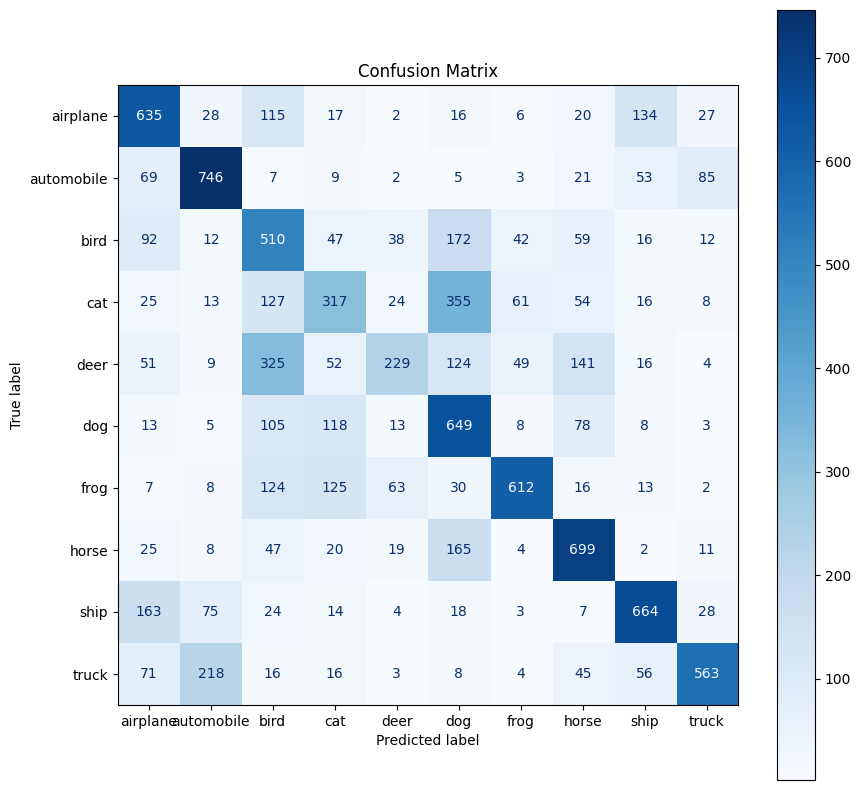

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
net.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"🧪 Test Accuracy: {100 * correct / total:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
